In [1]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
tf.set_random_seed(1)
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.compat.v1.Session(config=config)
import matplotlib.pyplot as plt
import PIL.Image as Image
from PIL import ImageOps
import math
import numpy as np
import tensorflow.keras.backend as K
from tensorflow.keras.utils import plot_model
import json
from tensorflow.keras.losses import mse
import os
import glob
import random
#import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.inception_v3 import InceptionV3
import datetime
from tensorflow.keras.layers import Dense, Input, concatenate, Dropout, Conv2D, MaxPooling2D, Flatten, Lambda, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
%matplotlib inline


Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
def euclidean_distance(y_true, y_pred):
    return K.sqrt(K.maximum(K.sum(K.square(y_pred - y_true), axis=-1, keepdims=True), K.epsilon()))

# Model

In [3]:
# feature extraction from input image
img = Input(shape = (112,112,2), name="input_image")

x = Conv2D(64, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv1")(img)
x = Conv2D(64, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv2")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool1')(x)
    
x = Conv2D(64, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv3")(x)
x = Conv2D(64, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv4")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool2')(x)
   
x = Conv2D(128, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv5")(x)
x = Conv2D(128, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv6")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2), strides=(2, 2), name='pool3')(x)
    
x = Conv2D(128, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv7")(x)
x = Conv2D(128, (3, 3), padding="same", strides=(1, 1), activation="relu", name="conv8")(x)
x = BatchNormalization()(x)
    
x = Flatten()(x)
x = Dropout(0.75, noise_shape=None, seed=None)(x)
x = Dense(1024, name='FC1')(x)
out = Dense(13, name='loss')(x)

# create model
model = Model(inputs=[img], outputs=[out])

# set output types
target = tf.compat.v1.placeholder(dtype='float32', shape=(13,1)) 

# get model summary
model.summary()

# compile model
model.compile(optimizer=Adam(lr=0.0015, beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss=euclidean_distance)
plot_model(model, to_file='model.png')


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 112, 112, 2)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 64)      1216      
_________________________________________________________________
conv2 (Conv2D)               (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 112, 112, 64)      256       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 56, 56, 64)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 56, 56, 64)        36928     
_________________________________________________________________
conv4 (Conv2D)               (None, 56, 56, 64)       

# Get data

In [4]:
data_path = "../Data/"

Left_images = np.load(data_path+"lir_cs.npy")
Right_images = np.load(data_path+"rir_cs.npy")
Fx = np.load(data_path+"fxr_cs.npy")
Fy = np.load(data_path+"fyr_cs.npy") 
U0 = np.load(data_path+"u0r_cs.npy") 
V0 = np.load(data_path+"v0r_cs.npy") 
Baseline = np.load(data_path+"br_cs.npy")
Disparity = np.load(data_path+"dr_cs.npy") 
Tx = np.load(data_path+"txr_cs.npy") 
Ty = np.load(data_path+"tyr_cs.npy") 
Tz = np.load(data_path+"tzr_cs.npy") 
Pitch = np.load(data_path+"pr_cs.npy")
X = np.load(data_path+"xr_cs.npy")
Y = np.load(data_path+"yr_cs.npy") 
Z = np.load(data_path+"zr_cs.npy")


In [5]:
Xr = []
Yr = []

for idx in range(len(Left_images)):
                
    l_im = Left_images[idx]
    l_im = l_im[:,:,0]
    r_im = Right_images[idx]
    r_im = r_im[:,:,0]
    training_image = np.dstack((l_im, r_im))
        
    Xr.append(training_image)
                
    Yr.append([Fx[idx], Fy[idx], U0[idx], V0[idx], Baseline[idx], Disparity[idx], Tx[idx], Ty[idx], Tz[idx], Pitch[idx], X[idx], Y[idx], Z[idx]])
    

In [6]:
data_path = "../Data/"

Left_images = np.load(data_path+"li.npy")
Right_images = np.load(data_path+"ri.npy")
Fx = np.load(data_path+"fx.npy")
Fy = np.load(data_path+"fy.npy") 
U0 = np.load(data_path+"u0.npy") 
V0 = np.load(data_path+"v0.npy") 
Baseline = np.load(data_path+"b.npy")
Disparity = np.load(data_path+"d.npy") 
Tx = np.load(data_path+"tx.npy") 
Ty = np.load(data_path+"ty.npy") 
Tz = np.load(data_path+"tz.npy") 
Pitch = np.load(data_path+"p.npy")
Xw = np.load(data_path+"x.npy")
Yw = np.load(data_path+"y.npy") 
Zw = np.load(data_path+"z.npy")




In [7]:
Xt = []
Yt = []

for idx in range(len(Left_images)):
                
    l_im = Left_images[idx]
    l_im = l_im[:,:,0]
    r_im = Right_images[idx]
    r_im = r_im[:,:,0]
    training_image = np.dstack((l_im, r_im))
        
    Xt.append(training_image)
                
    Yt.append([Fx[idx], Fy[idx], U0[idx], V0[idx], Baseline[idx], Disparity[idx], Tx[idx], Ty[idx], Tz[idx], Pitch[idx], Xw[idx], Yw[idx], Zw[idx]])
    

In [8]:
import os
from keras.callbacks import TensorBoard, LearningRateScheduler
from keras.applications.inception_v3 import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Model
from keras.layers import Dense, Flatten, Input
#from utils_regressor_focal_dist import RotNetDataGenerator, angle_error, CustomModelCheckpoint
from keras import optimizers
import numpy as np
import glob, math
from shutil import copyfile
import datetime, random
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session


model.load_weights('./new_logs/20221217-141802/model_multi_class/Best/weights_33_205.16.h5')



input_shape = (112, 112, 2)


output = model.predict(
    x=[Xr],
    batch_size=16,
    verbose=1
)

Using TensorFlow backend.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [9]:
np.save("../Data/p_dh_ad.npy", output)

In [9]:
np.shape(output)

(1525, 13)

Text(0, 0.5, '% Correct')

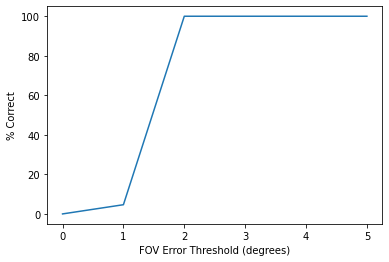

In [9]:
th_0 = 0
th_1 = 0
th_2 = 0
th_3 = 0
th_4 = 0
th_5 = 0

percent_correct = []

k = 0

for i  in range(np.shape(output)[0]):
    
    predicted_fov = 2*np.arctan(112/(2*output[i][0]))
    actual_fov = 2*np.arctan(112/(2*Yr[k][0]))
    
    if abs(predicted_fov - actual_fov) <= 0:
        
        th_0 += 1 
        
    if abs(predicted_fov - actual_fov) <= 1:
        
        th_1 += 1
        
    if abs(predicted_fov - actual_fov) <= 2:
        
        th_2 += 1
        
    if abs(predicted_fov - actual_fov) <= 3:
        
        th_3 += 1
        
    if abs(predicted_fov - actual_fov) <= 4:
        
        th_4 += 1
        
    if abs(predicted_fov - actual_fov) <= 5:
        
        th_5 += 1
        
    k += 1

percent_correct.append(th_0/np.shape(output)[0]*100)
percent_correct.append(th_1/np.shape(output)[0]*100)
percent_correct.append(th_2/np.shape(output)[0]*100)
percent_correct.append(th_3/np.shape(output)[0]*100)
percent_correct.append(th_4/np.shape(output)[0]*100)
percent_correct.append(th_5/np.shape(output)[0]*100)

plt.plot([0,1,2,3,4,5],percent_correct)
plt.xlabel("FOV Error Threshold (degrees)")
plt.ylabel("% Correct")

In [10]:
th_0, th_1, th_2, th_3, th_4, th_5

(0, 71, 1525, 1525, 1525, 1525)

In [11]:
th_0/np.shape(output)[0], th_1/np.shape(output)[0], th_2/np.shape(output)[0], th_3/np.shape(output)[0]

(0.0, 0.04655737704918033, 1.0, 1.0)

In [9]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0



key_counter = 0

for i in error.keys():
    
    k = 0

    for j  in range(np.shape(output)[0]):
        
        if key_counter == 0: 
    
            predicted_fx = output[j][key_counter]
            actual_fx = Y[k][key_counter]
    
            error[i] += abs(predicted_fx - actual_fx)
        
        if key_counter == 1: 
    
            predicted_fy = output[j][key_counter]
            actual_fy = Y[k][key_counter]
    
            error[i] += abs(predicted_fy - actual_fy)
        
        if key_counter == 2: 
    
            predicted_u0 = output[j][key_counter]
            actual_u0 = Y[k][key_counter]
    
            error[i] += abs(predicted_u0 - actual_u0)
        
        if key_counter == 3: 
    
            predicted_v0 = output[j][key_counter]
            actual_v0 = Y[k][key_counter]
    
            error[i] += abs(predicted_v0 - actual_v0)
        
        if key_counter == 4: 
    
            predicted_baseline = output[j][key_counter]
            actual_baseline = Y[k][key_counter]
    
            error[i] += abs(predicted_baseline - actual_baseline)
        
        if key_counter == 5: 
    
            predicted_disparity = output[j][key_counter]
            actual_disparity = Y[k][key_counter]
    
            error[i] += abs(predicted_disparity - actual_disparity)
        
        if key_counter == 6: 
    
            predicted_tx = output[j][key_counter]
            actual_tx = Y[k][key_counter]
    
            error[i] += abs(predicted_tx - actual_tx)
        
        if key_counter == 7: 
    
            predicted_ty = output[j][key_counter]
            actual_ty = Y[k][key_counter]
    
            error[i] += abs(predicted_ty - actual_ty)
        
        if key_counter == 8: 
    
            predicted_tz = output[j][key_counter]
            actual_tz = Y[k][key_counter]
    
            error[i] += abs(predicted_tz - actual_tz)
        
        if key_counter == 9: 
    
            predicted_pitch = output[j][key_counter]
            actual_pitch = Y[k][key_counter]
    
            error[i] += abs(predicted_pitch - actual_pitch)
        
        if key_counter == 10: 
    
            predicted_x = output[j][key_counter]
            actual_x = Y[k][key_counter]
    
            error[i] += abs(predicted_x - actual_x)
        
        if key_counter == 11: 
    
            predicted_y = output[j][key_counter]
            actual_y = Y[k][key_counter]
    
            error[i] += abs(predicted_y - actual_y)
        
        if key_counter == 12: 
    
            predicted_z = output[j][key_counter]
            actual_z = Y[k][key_counter]
    
            error[i] += abs(predicted_z - actual_z)
        
        k += 1
    
    
    error[i] /= np.shape(output)[0]
    
    key_counter += 1

print (error)

{'fx': 2187.835466098862, 'fy': 2186.780264598385, 'u0': 986.5188425963787, 'v0': 474.3703833170381, 'baseline': 2.084999640652746, 'disparity': 26.496626200378145, 'x': 0.33334779657561564, 'y': 3.392651533376868, 'z': 1.0609490097640724, 'pitch': 60.43388521361975, 'xworld': 38.12709313233318, 'yworld': 42.19958997466159, 'zworld': 64.4326267780633}


# Normalization


In [6]:

import math 

def normalize(x):
    
    return (math.atan(x) + 3.14/2) / 3.14

In [9]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0



key_counter = 0

for i in error.keys():
    
    k = 0

    for j  in range(np.shape(output)[0]):
        
        if key_counter == 0: 
    
            predicted_fx = output[j][key_counter]
            actual_fx = Y[k][key_counter]
    
            error[i] += normalize(abs(predicted_fx - actual_fx))
        
        if key_counter == 1: 
    
            predicted_fy = output[j][key_counter]
            actual_fy = Y[k][key_counter]
    
            error[i] += normalize(abs(predicted_fy - actual_fy))
        
        if key_counter == 2: 
    
            predicted_u0 = output[j][key_counter]
            actual_u0 = Y[k][key_counter]
    
            error[i] += normalize(abs(predicted_u0 - actual_u0))
        
        if key_counter == 3: 
    
            predicted_v0 = output[j][key_counter]
            actual_v0 = Y[k][key_counter]
    
            error[i] += normalize(abs(predicted_v0 - actual_v0))
        
        if key_counter == 4: 
    
            predicted_baseline = output[j][key_counter]
            actual_baseline = Y[k][key_counter]
    
            error[i] += normalize(abs(predicted_baseline - actual_baseline))
        
        if key_counter == 5: 
    
            predicted_disparity = output[j][key_counter]
            actual_disparity = Y[k][key_counter]
    
            error[i] += normalize(abs(predicted_disparity - actual_disparity))
        
        if key_counter == 6: 
    
            predicted_tx = output[j][key_counter]
            actual_tx = Y[k][key_counter]
    
            error[i] += normalize(abs(predicted_tx - actual_tx))
        
        if key_counter == 7: 
    
            predicted_ty = output[j][key_counter]
            actual_ty = Y[k][key_counter]
    
            error[i] += normalize(abs(predicted_ty - actual_ty))
        
        if key_counter == 8: 
    
            predicted_tz = output[j][key_counter]
            actual_tz = Y[k][key_counter]
    
            error[i] += normalize(abs(predicted_tz - actual_tz))
        
        if key_counter == 9: 
    
            predicted_pitch = output[j][key_counter]
            actual_pitch = Y[k][key_counter]
    
            error[i] += normalize(abs(predicted_pitch - actual_pitch))
        
        if key_counter == 10: 
    
            predicted_x = output[j][key_counter]
            actual_x = Y[k][key_counter]
    
            error[i] += normalize(abs(predicted_x - actual_x))
        
        if key_counter == 11: 
    
            predicted_y = output[j][key_counter]
            actual_y = Y[k][key_counter]
    
            error[i] += normalize(abs(predicted_y - actual_y))
        
        if key_counter == 12: 
    
            predicted_z = output[j][key_counter]
            actual_z = Y[k][key_counter]
    
            error[i] += normalize(abs(predicted_z - actual_z))
        
        k += 1
    
    
    error[i] /= np.shape(output)[0]
    
    key_counter += 1

print (error)

{'fx': 1.0001080045837623, 'fy': 1.0001079342904573, 'u0': 0.9999307839113891, 'v0': 0.9995822515913415, 'baseline': 0.8555105370378011, 'disparity': 0.9842707366638264, 'x': 0.595772400178889, 'y': 0.9081486833526228, 'z': 0.7458997135080934, 'pitch': 0.9948399250405411, 'xworld': 0.9812279206422281, 'yworld': 0.9917253436093755, 'zworld': 0.9949016278274857}


# Range Normalization

In [9]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0


min_fx = 1373.2275
max_fx = 2269.381661995158

min_fy = 1520.9558
max_fy = 2268.491

min_u0 = 382.5896
max_u0 = 1010.2414896422663

min_v0 = 33.014587
max_v0 = 504.2467619374397

min_baseline = 0.01699097
max_baseline = 23.478404679970208

min_disparity = 0.00021930835792538517
max_disparity = 88.691475

min_tx = 2.6702880859375e-05
max_tx = 21.68721567997021

min_ty = 0.8303014
max_ty = 33.99193576309983

min_tz = 0.0011047315597534357
max_tz = 16.97185265614626

min_pitch = 10.154588
max_pitch = 790.04095

min_xw = 0.00066566
max_xw = 6457.3228

min_yw = 0.0036399107805458186
max_yw = 2944.4214

min_zw = 0.01162195
max_zw = 1391.999



key_counter = 0

for i in error.keys():
    
    k = 0

    for j  in range(np.shape(output)[0]):
        
        if key_counter == 0: 
    
            predicted_fx = output[j][key_counter]
            actual_fx = Yr[k][key_counter]
    
            error[i] += (abs(predicted_fx - actual_fx) - min_fx)/(max_fx - min_fx)
        
        if key_counter == 1: 
    
            predicted_fy = output[j][key_counter]
            actual_fy = Yr[k][key_counter]
    
            error[i] += (abs(predicted_fy - actual_fy) - min_fy)/(max_fy - min_fy)
        
        if key_counter == 2: 
    
            predicted_u0 = output[j][key_counter]
            actual_u0 = Yr[k][key_counter]
    
            error[i] += (abs(predicted_u0 - actual_u0) - min_u0)/(max_u0 - min_u0)
        
        if key_counter == 3: 
    
            predicted_v0 = output[j][key_counter]
            actual_v0 = Yr[k][key_counter]
    
            error[i] += (abs(predicted_v0 - actual_v0) - min_v0)/(max_v0 - min_v0)
        
        if key_counter == 4: 
    
            predicted_baseline = output[j][key_counter]
            actual_baseline = Yr[k][key_counter]
    
            error[i] += (abs(predicted_baseline - actual_baseline) - min_baseline)/(max_baseline - min_baseline)
        
        if key_counter == 5: 
    
            predicted_disparity = output[j][key_counter]
            actual_disparity = Yr[k][key_counter]
    
            error[i] += (abs(predicted_disparity - actual_disparity) - min_disparity)/(max_disparity - min_disparity)
        
        if key_counter == 6: 
    
            predicted_tx = output[j][key_counter]
            actual_tx = Yr[k][key_counter]
    
            error[i] += (abs(predicted_tx - actual_tx) - min_tx)/(max_tx - min_tx)
        
        if key_counter == 7: 
    
            predicted_ty = output[j][key_counter]
            actual_ty = Yr[k][key_counter]
    
            error[i] += (abs(predicted_ty - actual_ty) - min_ty)/(max_ty - min_ty)
        
        if key_counter == 8: 
    
            predicted_tz = output[j][key_counter]
            actual_tz = Yr[k][key_counter]
    
            error[i] += (abs(predicted_tz - actual_tz) - min_tz)/(max_tz - min_tz)
        
        if key_counter == 9: 
    
            predicted_pitch = output[j][key_counter]
            actual_pitch = Yr[k][key_counter]
    
            error[i] += (abs(predicted_pitch - actual_pitch) - min_pitch)/(max_pitch - min_pitch)
        
        if key_counter == 10: 
    
            predicted_x = output[j][key_counter]
            actual_x = Yr[k][key_counter]
    
            error[i] += (abs(predicted_x - actual_x) - min_xw)/(max_xw - min_xw)
        
        if key_counter == 11: 
    
            predicted_y = output[j][key_counter]
            actual_y = Yr[k][key_counter]
    
            error[i] += (abs(predicted_y - actual_y) - min_yw)/(max_yw - min_yw)
        
        if key_counter == 12: 
    
            predicted_z = output[j][key_counter]
            actual_z = Yr[k][key_counter]
    
            error[i] += (abs(predicted_z - actual_z) - min_zw)/(max_zw - min_zw)
        
        k += 1
    
    
    error[i] /= np.shape(output)[0]
    
    key_counter += 1

print (error)

{'fx': 0.9090042769932767, 'fy': 0.8906931266894667, 'u0': 0.9622041334737359, 'v0': 0.9365994509513459, 'baseline': 0.08814510055606907, 'disparity': 0.2987488077081888, 'x': 0.015369492747394867, 'y': 0.07726851171811024, 'z': 0.0624512415666064, 'pitch': 0.06447003007550685, 'xworld': 0.005904371298061305, 'yworld': 0.014330829896435091, 'zworld': 0.04627987713387813}


# Normalized MAE

In [12]:


error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0


mean_fx = 2264.2327510917034

mean_fy = 2253.868010102392

mean_u0 = 1081.5683842794758

mean_v0 = 514.9599912663754

mean_baseline = 0.21329831659388643

mean_disparity = 14.895290324781659

mean_tx = 1.6999999999999993

mean_ty = 0.03842794759825327

mean_tz = 1.2281222707423585

mean_pitch = 0.0416943231441048

mean_xw = 76.88999830085741

mean_yw = 35.61612170597476

mean_zw = 15.00800213427252



key_counter = 0

for i in error.keys():
    
    k = 0

    for j  in range(np.shape(output)[0]):
        
        if key_counter == 0: 
    
            predicted_fx = output[j][key_counter]
            actual_fx = Yr[k][key_counter]
    
            error[i] += abs(predicted_fx - actual_fx) / mean_fx
        
        if key_counter == 1: 
    
            predicted_fy = output[j][key_counter]
            actual_fy = Yr[k][key_counter]
    
            error[i] += abs(predicted_fy - actual_fy) / mean_fy
        
        if key_counter == 2: 
    
            predicted_u0 = output[j][key_counter]
            actual_u0 = Yr[k][key_counter]
    
            error[i] += abs(predicted_u0 - actual_u0) / mean_u0
        
        if key_counter == 3: 
    
            predicted_v0 = output[j][key_counter]
            actual_v0 = Yr[k][key_counter]
    
            error[i] += abs(predicted_v0 - actual_v0) / mean_v0
        
        if key_counter == 4: 
    
            predicted_baseline = output[j][key_counter]
            actual_baseline = Yr[k][key_counter]
    
            error[i] += abs(predicted_baseline - actual_baseline) / mean_baseline
        
        if key_counter == 5: 
    
            predicted_disparity = output[j][key_counter]
            actual_disparity = Yr[k][key_counter]
    
            error[i] += abs(predicted_disparity - actual_disparity) / mean_disparity
        
        if key_counter == 6: 
    
            predicted_tx = output[j][key_counter]
            actual_tx = Yr[k][key_counter]
    
            error[i] += abs(predicted_tx - actual_tx) / mean_tx
        
        if key_counter == 7: 
    
            predicted_ty = output[j][key_counter]
            actual_ty = Yr[k][key_counter]
    
            error[i] += abs(predicted_ty - actual_ty) / mean_ty
        
        if key_counter == 8: 
    
            predicted_tz = output[j][key_counter]
            actual_tz = Yr[k][key_counter]
    
            error[i] += abs(predicted_tz - actual_tz) / mean_tz
        
        if key_counter == 9: 
    
            predicted_pitch = output[j][key_counter]
            actual_pitch = Yr[k][key_counter]
    
            error[i] += abs(predicted_pitch - actual_pitch) / mean_pitch
        
        if key_counter == 10: 
    
            predicted_x = output[j][key_counter]
            actual_x = Yr[k][key_counter]
    
            error[i] += abs(predicted_x - actual_x) / mean_xw
        
        if key_counter == 11: 
    
            predicted_y = output[j][key_counter]
            actual_y = Yr[k][key_counter]
    
            error[i] += abs(predicted_y - actual_y) / mean_yw
        
        if key_counter == 12: 
    
            predicted_z = output[j][key_counter]
            actual_z = Yr[k][key_counter]
    
            error[i] += abs(predicted_z - actual_z) / mean_zw
        
        k += 1
    
    
    error[i] /= np.shape(output)[0]
    
    key_counter += 1

print (error)

{'fx': 0.9677991498218087, 'fy': 0.9675967328701836, 'u0': 0.9484191611624287, 'v0': 0.8924480130503463, 'baseline': 438.73004187891945, 'disparity': 1.849384238230214, 'x': 55.93242981560316, 'y': 37.543363058564395, 'z': 2.3388879810332663, 'pitch': 107.5393534634421, 'xworld': 2.2140159386964218, 'yworld': 0.9691563571940817, 'zworld': 15.282349395321944}


In [25]:
np.shape(output)

(23796, 13)

In [26]:
k

79320

In [27]:
sum(error.values())

163.44208461933255

In [10]:
predicted_fx = np.average(Yt[:int(len(Yt)*0.7)][0])
predicted_fy = np.average(Yt[:int(len(Yt)*0.7)][1])
predicted_u0 = np.average(Yt[:int(len(Yt)*0.7)][2])
predicted_v0 = np.average(Yt[:int(len(Yt)*0.7)][3])
predicted_baseline = np.average(Yt[:int(len(Yt)*0.7)][4])
predicted_disparity = np.average(Yt[:int(len(Yt)*0.7)][5])
predicted_tx = np.average(Yt[:int(len(Yt)*0.7)][6])
predicted_ty = np.average(Yt[:int(len(Yt)*0.7)][7])
predicted_tz = np.average(Yt[:int(len(Yt)*0.7)][8])
predicted_pitch = np.average(Yt[:int(len(Yt)*0.7)][9])
predicted_x = np.average(Yt[:int(len(Yt)*0.7)][10])
predicted_y = np.average(Yt[:int(len(Yt)*0.7)][11])
predicted_z = np.average(Yt[:int(len(Yt)*0.7)][12])



In [11]:
output = [predicted_fx, predicted_fy, predicted_u0, predicted_v0, predicted_baseline, predicted_disparity, predicted_tx, predicted_ty, predicted_tz, predicted_pitch, predicted_x, predicted_y, predicted_z]
np.save("../Data/p_avg_ad.npy", output)

# Average

In [9]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0

predicted_fx = np.average(Yt[:int(len(Yt)*0.7)][0])
predicted_fy = np.average(Yt[:int(len(Yt)*0.7)][1])
predicted_u0 = np.average(Yt[:int(len(Yt)*0.7)][2])
predicted_v0 = np.average(Yt[:int(len(Yt)*0.7)][3])
predicted_baseline = np.average(Yt[:int(len(Yt)*0.7)][4])
predicted_disparity = np.average(Yt[:int(len(Yt)*0.7)][5])
predicted_tx = np.average(Yt[:int(len(Yt)*0.7)][6])
predicted_ty = np.average(Yt[:int(len(Yt)*0.7)][7])
predicted_tz = np.average(Yt[:int(len(Yt)*0.7)][8])
predicted_pitch = np.average(Yt[:int(len(Yt)*0.7)][9])
predicted_x = np.average(Yt[:int(len(Yt)*0.7)][10])
predicted_y = np.average(Yt[:int(len(Yt)*0.7)][11])
predicted_z = np.average(Yt[:int(len(Yt)*0.7)][12])



key_counter = 0

for i in error.keys():
    
    k = 0

    for j in range(np.shape(Xr)[0]):
        
        if key_counter == 0: 
    
            
            actual_fx = Yr[k][key_counter]
    
            error[i] += abs(predicted_fx - actual_fx)
        
        if key_counter == 1: 
    
            
            actual_fy = Yr[k][key_counter]
    
            error[i] += abs(predicted_fy - actual_fy)
        
        if key_counter == 2: 
    
            
            actual_u0 = Yr[k][key_counter]
    
            error[i] += abs(predicted_u0 - actual_u0)
        
        if key_counter == 3: 
    
            
            actual_v0 = Yr[k][key_counter]
    
            error[i] += abs(predicted_v0 - actual_v0)
        
        if key_counter == 4: 
    
            
            actual_baseline = Yr[k][key_counter]
    
            error[i] += abs(predicted_baseline - actual_baseline)
        
        if key_counter == 5: 
    
            
            actual_disparity = Yr[k][key_counter]
    
            error[i] += abs(predicted_disparity - actual_disparity)
        
        if key_counter == 6: 
    
            
            actual_tx = Yr[k][key_counter]
    
            error[i] += abs(predicted_tx - actual_tx)
        
        if key_counter == 7: 
    
            
            actual_ty = Yr[k][key_counter]
    
            error[i] += abs(predicted_ty - actual_ty)
        
        if key_counter == 8: 
    
            
            actual_tz = Yr[k][key_counter]
    
            error[i] += abs(predicted_tz - actual_tz)
        
        if key_counter == 9: 
    
            
            actual_pitch = Yr[k][key_counter]
    
            error[i] += abs(predicted_pitch - actual_pitch)
        
        if key_counter == 10: 
    
            
            actual_x = Yr[k][key_counter]
    
            error[i] += abs(predicted_x - actual_x)
        
        if key_counter == 11: 
    
            
            actual_y = Yr[k][key_counter]
    
            error[i] += abs(predicted_y - actual_y)
        
        if key_counter == 12: 
    
            
            actual_z = Yr[k][key_counter]
    
            error[i] += abs(predicted_z - actual_z)
        
        k += 1
    
    
    error[i] /= np.shape(Xr)[0]
    
    key_counter += 1

print (error)


{'fx': 2269.381661995255, 'fy': 2262.306306562095, 'u0': 1010.2414896422918, 'v0': 504.24676193741243, 'baseline': 23.47840467996938, 'disparity': 10.57278330133617, 'x': 21.6872156799712, 'y': 33.99193576310055, 'z': 16.971852656146442, 'pitch': 21.613087591247695, 'xworld': 22.69346716041614, 'yworld': 10.162228961873039, 'zworld': 56.7827792368082}


# Normalization

In [11]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0

predicted_fx = np.average(Yt[:int(len(Yt)*0.7)][0])
predicted_fy = np.average(Yt[:int(len(Yt)*0.7)][1])
predicted_u0 = np.average(Yt[:int(len(Yt)*0.7)][2])
predicted_v0 = np.average(Yt[:int(len(Yt)*0.7)][3])
predicted_baseline = np.average(Yt[:int(len(Yt)*0.7)][4])
predicted_disparity = np.average(Yt[:int(len(Yt)*0.7)][5])
predicted_tx = np.average(Yt[:int(len(Yt)*0.7)][6])
predicted_ty = np.average(Yt[:int(len(Yt)*0.7)][7])
predicted_tz = np.average(Yt[:int(len(Yt)*0.7)][8])
predicted_pitch = np.average(Yt[:int(len(Yt)*0.7)][9])
predicted_x = np.average(Yt[:int(len(Yt)*0.7)][10])
predicted_y = np.average(Yt[:int(len(Yt)*0.7)][11])
predicted_z = np.average(Yt[:int(len(Yt)*0.7)][12])



key_counter = 0

for i in error.keys():
    
    k = 0

    for j in range(np.shape(output)[0]):
        
        if key_counter == 0: 
    
            
            actual_fx = Yr[k][key_counter]
    
            error[i] += normalize(abs(predicted_fx - actual_fx))
        
        if key_counter == 1: 
    
            
            actual_fy = Yr[k][key_counter]
    
            error[i] += normalize(abs(predicted_fy - actual_fy))
        
        if key_counter == 2: 
    
            
            actual_u0 = Yr[k][key_counter]
    
            error[i] += normalize(abs(predicted_u0 - actual_u0))
        
        if key_counter == 3: 
    
            
            actual_v0 = Yr[k][key_counter]
    
            error[i] += normalize(abs(predicted_v0 - actual_v0))
        
        if key_counter == 4: 
    
            
            actual_baseline = Yr[k][key_counter]
    
            error[i] += normalize(abs(predicted_baseline - actual_baseline))
        
        if key_counter == 5: 
    
            
            actual_disparity = Yr[k][key_counter]
    
            error[i] += normalize(abs(predicted_disparity - actual_disparity))
        
        if key_counter == 6: 
    
            
            actual_tx = Yr[k][key_counter]
    
            error[i] += normalize(abs(predicted_tx - actual_tx))
        
        if key_counter == 7: 
    
            
            actual_ty = Yr[k][key_counter]
    
            error[i] += normalize(abs(predicted_ty - actual_ty))
        
        if key_counter == 8: 
    
            
            actual_tz = Yr[k][key_counter]
    
            error[i] += normalize(abs(predicted_tz - actual_tz))
        
        if key_counter == 9: 
    
            
            actual_pitch = Yr[k][key_counter]
    
            error[i] += normalize(abs(predicted_pitch - actual_pitch))
        
        if key_counter == 10: 
    
            
            actual_x = Yr[k][key_counter]
    
            error[i] += normalize(abs(predicted_x - actual_x))
        
        if key_counter == 11: 
    
            
            actual_y = Yr[k][key_counter]
    
            error[i] += normalize(abs(predicted_y - actual_y))
        
        if key_counter == 12: 
    
            
            actual_z = Yr[k][key_counter]
    
            error[i] += normalize(abs(predicted_z - actual_z))
        
        k += 1
    
    
    error[i] /= np.shape(output)[0]
    
    key_counter += 1

print (error)


{'fx': 1.000113273298794, 'fy': 1.0001128344048473, 'u0': 0.9999383645805593, 'v0': 0.9996220297380602, 'baseline': 0.986697363940048, 'disparity': 0.9056097393730261, 'x': 0.9855792514269232, 'y': 0.9908872824791402, 'z': 0.9815105999547723, 'pitch': 0.985528993220368, 'xworld': 0.94620667260155, 'yworld': 0.9048230279283548, 'zworld': 0.9942331592240069}


# Range Normalization

In [10]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0

min_fx = 1373.2275
max_fx = 2269.381661995158

min_fy = 1520.9558
max_fy = 2268.491

min_u0 = 382.5896
max_u0 = 1010.2414896422663

min_v0 = 33.014587
max_v0 = 504.2467619374397

min_baseline = 0.01699097
max_baseline = 23.478404679970208

min_disparity = 0.00021930835792538517
max_disparity = 88.691475

min_tx = 2.6702880859375e-05
max_tx = 21.68721567997021

min_ty = 0.8303014
max_ty = 33.99193576309983

min_tz = 0.0011047315597534357
max_tz = 16.97185265614626

min_pitch = 10.154588
max_pitch = 790.04095

min_xw = 0.00066566
max_xw = 6457.3228

min_yw = 0.0036399107805458186
max_yw = 2944.4214

min_zw = 0.01162195
max_zw = 1391.999



predicted_fx = np.average(Yt[:int(len(Yt)*0.7)][0])
predicted_fy = np.average(Yt[:int(len(Yt)*0.7)][1])
predicted_u0 = np.average(Yt[:int(len(Yt)*0.7)][2])
predicted_v0 = np.average(Yt[:int(len(Yt)*0.7)][3])
predicted_baseline = np.average(Yt[:int(len(Yt)*0.7)][4])
predicted_disparity = np.average(Yt[:int(len(Yt)*0.7)][5])
predicted_tx = np.average(Yt[:int(len(Yt)*0.7)][6])
predicted_ty = np.average(Yt[:int(len(Yt)*0.7)][7])
predicted_tz = np.average(Yt[:int(len(Yt)*0.7)][8])
predicted_pitch = np.average(Yt[:int(len(Yt)*0.7)][9])
predicted_x = np.average(Yt[:int(len(Yt)*0.7)][10])
predicted_y = np.average(Yt[:int(len(Yt)*0.7)][11])
predicted_z = np.average(Yt[:int(len(Yt)*0.7)][12])

key_counter = 0

for i in error.keys():
    
    k = 0

    for j  in range(np.shape(Xr)[0]):
        
        if key_counter == 0: 
    
            
            actual_fx = Yr[k][key_counter]
    
            error[i] += (abs(predicted_fx - actual_fx) - min_fx)/(max_fx - min_fx)
        
        if key_counter == 1: 
    
            
            actual_fy = Yr[k][key_counter]
    
            error[i] += (abs(predicted_fy - actual_fy) - min_fy)/(max_fy - min_fy)
        
        if key_counter == 2: 
    
            
            actual_u0 = Yr[k][key_counter]
    
            error[i] += (abs(predicted_u0 - actual_u0) - min_u0)/(max_u0 - min_u0)
        
        if key_counter == 3: 
    
            
            actual_v0 = Yr[k][key_counter]
    
            error[i] += (abs(predicted_v0 - actual_v0) - min_v0)/(max_v0 - min_v0)
        
        if key_counter == 4: 
    
            
            actual_baseline = Yr[k][key_counter]
    
            error[i] += (abs(predicted_baseline - actual_baseline) - min_baseline)/(max_baseline - min_baseline)
        
        if key_counter == 5: 
    
            
            actual_disparity = Yr[k][key_counter]
    
            error[i] += (abs(predicted_disparity - actual_disparity) - min_disparity)/(max_disparity - min_disparity)
        
        if key_counter == 6: 
    
            
            actual_tx = Yr[k][key_counter]
    
            error[i] += (abs(predicted_tx - actual_tx) - min_tx)/(max_tx - min_tx)
        
        if key_counter == 7: 
    
            
            actual_ty = Yr[k][key_counter]
    
            error[i] += (abs(predicted_ty - actual_ty) - min_ty)/(max_ty - min_ty)
        
        if key_counter == 8: 
    
            
            actual_tz = Yr[k][key_counter]
    
            error[i] += (abs(predicted_tz - actual_tz) - min_tz)/(max_tz - min_tz)
        
        if key_counter == 9: 
    
            
            actual_pitch = Yr[k][key_counter]
    
            error[i] += (abs(predicted_pitch - actual_pitch) - min_pitch)/(max_pitch - min_pitch)
        
        if key_counter == 10: 
    
            
            actual_x = Yr[k][key_counter]
    
            error[i] += (abs(predicted_x - actual_x) - min_xw)/(max_xw - min_xw)
        
        if key_counter == 11: 
    
            
            actual_y = Yr[k][key_counter]
    
            error[i] += (abs(predicted_y - actual_y) - min_yw)/(max_yw - min_yw)
        
        if key_counter == 12: 
    
            
            actual_z = Yr[k][key_counter]
    
            error[i] += (abs(predicted_z - actual_z) - min_zw)/(max_zw - min_zw)
        
        k += 1
    
    
    error[i] /= np.shape(Xr)[0]
    
    key_counter += 1

print (error)


{'fx': 1.0, 'fy': 0.9917265522238852, 'u0': 1.0, 'v0': 1.0, 'baseline': 1.0, 'disparity': 0.11920638523527545, 'x': 1.0, 'y': 1.0, 'z': 1.0, 'pitch': 0.014692524641489482, 'xworld': 0.003514274342879068, 'yworld': 0.0034501181146199414, 'zworld': 0.04078424717208099}


# Normalized MAE

In [9]:
error = {}

error["fx"] = 0
error["fy"] = 0
error["u0"] = 0
error["v0"] = 0
error["baseline"] = 0
error["disparity"] = 0
error["x"] = 0
error["y"] = 0
error["z"] = 0
error["pitch"] = 0
error["xworld"] = 0
error["yworld"] = 0
error["zworld"] = 0

mean_fx = 2264.2327510917034

mean_fy = 2253.868010102392

mean_u0 = 1081.5683842794758

mean_v0 = 514.9599912663754

mean_baseline = 0.21329831659388643

mean_disparity = 14.895290324781659

mean_tx = 1.6999999999999993

mean_ty = 0.03842794759825327

mean_tz = 1.2281222707423585

mean_pitch = 0.0416943231441048

mean_xw = 76.88999830085741

mean_yw = 35.61612170597476

mean_zw = 15.00800213427252



predicted_fx = np.average(Yt[0])
predicted_fy = np.average(Yt[1])
predicted_u0 = np.average(Yt[2])
predicted_v0 = np.average(Yt[3])
predicted_baseline = np.average(Yt[4])
predicted_disparity = np.average(Yt[5])
predicted_tx = np.average(Yt[6])
predicted_ty = np.average(Yt[7])
predicted_tz = np.average(Yt[8])
predicted_pitch = np.average(Yt[9])
predicted_x = np.average(Yt[10])
predicted_y = np.average(Yt[11])
predicted_z = np.average(Yt[12])

key_counter = 0

for i in error.keys():
    
    k = 0

    for j  in range(np.shape(Xr)[0]):
        
        if key_counter == 0: 
    
            
            actual_fx = Yr[k][key_counter]
    
            error[i] += abs(predicted_fx - actual_fx) / mean_fx
        
        if key_counter == 1: 
    
            
            actual_fy = Yr[k][key_counter]
    
            error[i] += abs(predicted_fy - actual_fy) / mean_fy
        
        if key_counter == 2: 
    
            
            actual_u0 = Yr[k][key_counter]
    
            error[i] += abs(predicted_u0 - actual_u0) / mean_u0
        
        if key_counter == 3: 
    
            
            actual_v0 = Yr[k][key_counter]
    
            error[i] += abs(predicted_v0 - actual_v0) / mean_v0
        
        if key_counter == 4: 
    
            
            actual_baseline = Yr[k][key_counter]
    
            error[i] += abs(predicted_baseline - actual_baseline) / mean_baseline
        
        if key_counter == 5: 
    
            
            actual_disparity = Yr[k][key_counter]
    
            error[i] += abs(predicted_disparity - actual_disparity) / mean_disparity
        
        if key_counter == 6: 
    
            
            actual_tx = Yr[k][key_counter]
    
            error[i] += abs(predicted_tx - actual_tx) / mean_tx
        
        if key_counter == 7: 
    
            
            actual_ty = Yr[k][key_counter]
    
            error[i] += abs(predicted_ty - actual_ty) / mean_ty
        
        if key_counter == 8: 
    
            
            actual_tz = Yr[k][key_counter]
    
            error[i] += abs(predicted_tz - actual_tz) / mean_tz
        
        if key_counter == 9: 
    
            
            actual_pitch = Yr[k][key_counter]
    
            error[i] += abs(predicted_pitch - actual_pitch) / mean_pitch
        
        if key_counter == 10: 
    
            
            actual_x = Yr[k][key_counter]
    
            error[i] += abs(predicted_x - actual_x) / mean_xw
        
        if key_counter == 11: 
    
            
            actual_y = Yr[k][key_counter]
    
            error[i] += abs(predicted_y - actual_y) / mean_yw
        
        if key_counter == 12: 
    
            
            actual_z = Yr[k][key_counter]
    
            error[i] += abs(predicted_z - actual_z) / mean_zw
        
        k += 1
    
    
    error[i] /= np.shape(Xr)[0]
    
    key_counter += 1

print (error)


{'fx': 1.0001103862974867, 'fy': 1.0141456588127125, 'u0': 1.016532210544775, 'v0': 1.0218263427471173, 'baseline': 356.94109499654724, 'disparity': 6.659829652027056, 'x': 36.49061874398264, 'y': 1061.8121243312398, 'z': 5.116389113574436, 'pitch': 1225.3277240303735, 'xworld': 1.128171993851108, 'yworld': 5.709929376925974, 'zworld': 4.403040387984803}


Text(0, 0.5, '% Correct')

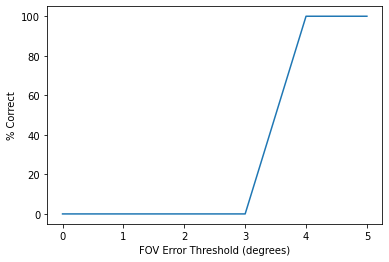

In [10]:
th_0 = 0
th_1 = 0
th_2 = 0
th_3 = 0
th_4 = 0
th_5 = 0

percent_correct = []

k = 0

for i  in range(np.shape(output)[0]):
    
    predicted_fov = 2*np.arctan(112/(2*predicted_fx))
    actual_fov = 2*np.arctan(112/(2*Yr[k][0]))
    
    if abs(predicted_fov - actual_fov) <= 0:
        
        th_0 += 1 
        
    if abs(predicted_fov - actual_fov) <= 1:
        
        th_1 += 1
        
    if abs(predicted_fov - actual_fov) <= 2:
        
        th_2 += 1
        
    if abs(predicted_fov - actual_fov) <= 3:
        
        th_3 += 1
        
    if abs(predicted_fov - actual_fov) <= 4:
        
        th_4 += 1
        
    if abs(predicted_fov - actual_fov) <= 5:
        
        th_5 += 1
        
    k += 1

percent_correct.append(th_0/np.shape(output)[0]*100)
percent_correct.append(th_1/np.shape(output)[0]*100)
percent_correct.append(th_2/np.shape(output)[0]*100)
percent_correct.append(th_3/np.shape(output)[0]*100)
percent_correct.append(th_4/np.shape(output)[0]*100)
percent_correct.append(th_5/np.shape(output)[0]*100)

plt.plot([0,1,2,3,4,5],percent_correct)
plt.xlabel("FOV Error Threshold (degrees)")
plt.ylabel("% Correct")

In [11]:
th_0, th_1, th_2, th_3, th_4, th_5

(0, 0, 0, 0, 1525, 1525)

In [13]:
th_0/np.shape(output)[0], th_1/np.shape(output)[0], th_2/np.shape(output)[0], th_3/np.shape(output)[0], th_4/np.shape(output)[0]

(0.0, 0.0, 0.0, 0.0, 1.0)